In [2]:
import sys
sys.path.append('../../../src')
from helpers import *
import copy
import matplotlib.ticker as ticker
import matplotlib as mpl
from scipy.optimize import minimize
from scipy.integrate import odeint
from matplotlib.ticker import FuncFormatter
%matplotlib notebook

if not os.path.exists('Figs'):
    os.mkdir('Figs')

In [3]:
svr = 0.174
D = 0.005
dosage = 1.04e-8 / 0.62
pf = 42.84952328748557  # see prefactor notebook

In [4]:
def lighten(color, amount=1.8):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

### Equilibrium model

In [5]:
def concentration_tree(d, cfrac_c1frac_smfrac_m1frac_e1frac):
    
    """
    d = total protein
    
    Concentrations described by a series of fractions (0-1)
    
    c (cfrac)
        c1 (c1frac)
        c2
    s
        m (smfrac)
            m1 (m1frac)
            m2
        e
            e1 (e1frac)
            e2

    """
    
    cfrac, c1frac, smfrac, m1frac, e1frac = [1 / (1 + np.exp(- i)) for i in cfrac_c1frac_smfrac_m1frac_e1frac]
    c = d * cfrac
    s = d * (1 - cfrac)
    m = s * smfrac * (1 / (svr*D))
    e = s * (1 - smfrac) * (1 / (svr*D))  
    c1 = c * c1frac
    c2 = (c - c1) 
    m1 = m * m1frac
    m2 = (m - m1)
    e1 = e * e1frac
    e2 = (e - e1)
    return c1, c2, m1, m2, e1, e2


def calc_loss(cfrac_c1frac_smfrac_m1frac_e1frac, dosage, wd, wm, we):

    # Concentrations
    c1, c2, m1, m2, e1, e2 = concentration_tree(dosage, cfrac_c1frac_smfrac_m1frac_e1frac)
        
    # Enthalpic terms
    wc1 = 0
    wc2 = wd
    wm1 = wm
    wm2 = 2 * wm + wd
    we1 = we
    we2 = 2 * we + wd

    # Chemical potentials
    muc1 = np.log(c1) - wc1
    muc2 = np.log(c2) - wc2
    mum1 = np.log(m1) - wm1
    mum2 = np.log(m2) - wm2
    mue1 = np.log(e1) - we1
    mue2 = np.log(e2) - we2

    # Loss
    mu_all = np.array([2 * muc1, muc2, 2 * mum1, mum2, 2 * mue1, mue2])
    loss = np.sum((mu_all[:, np.newaxis] - mu_all[np.newaxis, :]) ** 2)
        
    return loss


def func_equilibrium(wm, wd, wi):

    # Optimise
    x0 = [0, 0, 0, 0, 0]
    res = minimize(calc_loss, x0=x0, args=(dosage, wd, wm, wi)).x

    # Get concentrations
    c1, c2, m1, m2, e1, e2 = concentration_tree(dosage, res)
    c_tot = c1 + c2
    m_tot = (m1 + m2) * svr * D
    e_tot = (e1 + e2) * svr * D

#     # Fraction in membrane bound state
#     return [c_tot / d, m_tot / d, e_tot / d]
    return [c1 + c2, m1 + m2, e1 + e2]

###  Kinetic model

In [6]:
from scipy.integrate import odeint

def kon(c, wm, wd, pf=pf):
    mu_c = np.log(c) - 0.5 * np.log(2 * np.exp(wd) * c + np.sqrt(4 * np.exp(wd) * c + 1) + 1)
    s_on = np.exp(mu_c)
    kon = s_on / c
    return kon * pf


def koff(m, wm, wd, pf=pf):
    mu_m = np.log(m) - wm - 0.5 * np.log(2 * np.exp(wd) * m + np.sqrt(4 * np.exp(wd) * m + 1) + 1)
    s_off = np.exp(mu_m)
    koff = s_off / m
    return koff * pf


def dxdt(X, wd, wm, we):
    c = X[0]
    m = X[1]
    e = X[2]

    r = np.zeros(4)
    r[0] = kon(c, wm, wd) * c  # onto membrane
    r[1] = koff(m, wm, wd) * m  # off membrane
    r[2] = kon(c, we, wd) * c  # onto endosomes
    r[3] = koff(e, we, wd) * e  # off endosomes

    dc = svr * D * (- r[0] + r[1] - r[2] + r[3])
    dm = + r[0] - r[1]
    de = + r[2] - r[3]

    return dc, dm, de

def func_kinetic(wm, wd, wi, timepoints, x0=None):
    
    # Initial conditions
    if x0 is None:
        x0 = [dosage, 1e-100, 1e-100]

    # Solve
    def ode_func(X, t=0):
        return dxdt(X, wd=wd, wm=wm, we=wi)

    sol = odeint(ode_func, x0, t=timepoints)
    return sol

### Changing wd

In [7]:
def _fake_log(x, pos):
    return r'$10^{%d}$' % (x)
fake_log = FuncFormatter(_fake_log)

<IPython.core.display.Javascript object>


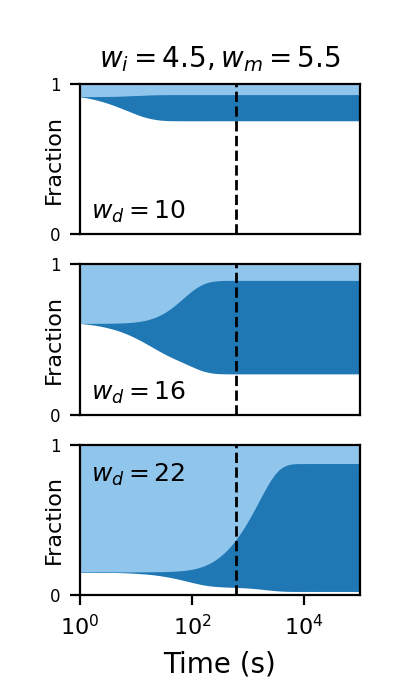

In [8]:
wi = 4.5
wm = 5.5
wd_vals = [10, 16, 22]
tmin, tmax = 0, 5

timepoints = 10 ** np.linspace(tmin, tmax, 501)
sol0 = np.zeros([len(wd_vals), 3])
sol = np.zeros([len(wd_vals), len(timepoints), 3])
solinf = np.zeros([len(wd_vals), 3])
for i, wd in enumerate(wd_vals):
    
    # Time zero
    sol0[i, :] = func_equilibrium(wm=0, wd=wd, wi=wi)
    
    # Timelapse
    sol[i, :, :] = func_kinetic(wm=wm, wd=wd, wi=wi, x0=sol0[i, :], timepoints=timepoints)
    
    # Time infinity
    solinf[i, :] = func_equilibrium(wm=wm, wd=wd, wi=wi)

    
fig, axs = plt.subplots(3, 1)
for i, (ax, s) in enumerate(zip(axs, sol)):
    ax.fill_between(x=np.log10(timepoints), y1=0, y2=s[:, 0]/ dosage, color='w')
    ax.fill_between(x=np.log10(timepoints), y1=s[:, 0] / dosage, 
                    y2=s[:, 0] / dosage + s[:, 1] * svr * D / dosage, color='tab:blue')
    ax.fill_between(x=np.log10(timepoints), y1=1, y2 = 1 - s[:, 2] * svr * D / dosage, color=lighten('tab:blue'))
    ax.set_ylim(0, 1)
    ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Fraction', fontsize=8, labelpad=-5)
    ax.set_yticks([0, 1])
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=6)
    ax.axvline(np.log10(600), linestyle='--', c='k', linewidth=1)


axs[0].text(x=tmin + 0.2, y=0.1, s=r'$w_d=%s$' % wd_vals[0], fontsize=9)
axs[1].text(x=tmin + 0.2, y=0.1, s=r'$w_d=%s$' % wd_vals[1], fontsize=9)
axs[2].text(x=tmin + 0.2, y=0.75, s=r'$w_d=%s$' % wd_vals[2], fontsize=9)    
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].xaxis.set_major_formatter(fake_log)
axs[2].set_xlabel('Time (s)')
axs[0].set_title(r'$w_i=%s, w_m=%s$' % (wi, wm), fontsize=10)
fig.set_size_inches(2, 3.5)
fig.subplots_adjust(left=0.2, bottom=0.15)
fig.savefig('Figs/timelapse.png', dpi=600, transparent=True)

### Pie chart grid

599.7910762555094


<IPython.core.display.Javascript object>


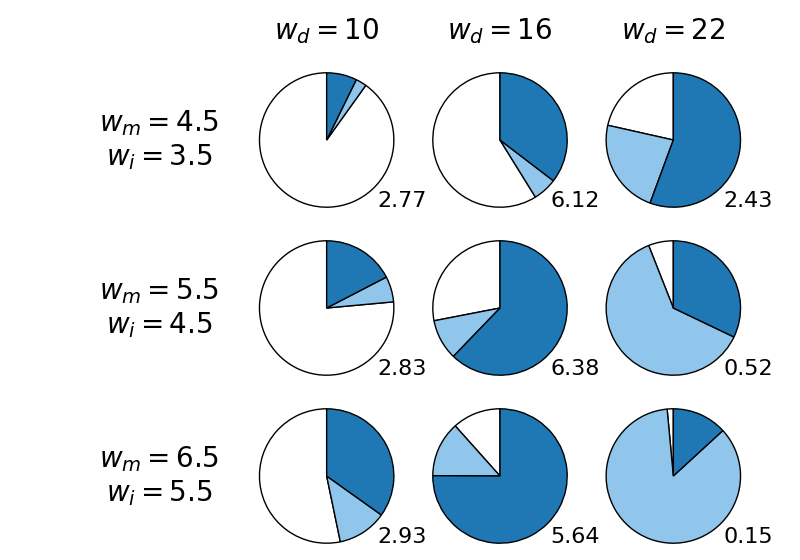

1.0000000000000078
0.9999999999999659
0.9999999999999999
0.9999999999999989
1.0000000000000162
1.0000000000000002
0.9999999999999969
1.0
1.0000000000008644


In [9]:
wms = [4.5, 5.5, 6.5]
wds = [10, 16, 22]

timepoints = 10 ** np.linspace(0, 6, 1001)
sol = np.zeros([len(wms), len(wds), 3])
a = np.argmin(abs(timepoints - 600))
print(timepoints[a])
for i, wm in enumerate(wms):
    for j, wd in enumerate(wds):
        sol0 = func_equilibrium(wm=0, wd=wd, wi=wm-1)
        sol[i, j, :] = func_kinetic(wm=wm, wd=wd, wi=wm-1, x0=sol0, timepoints=timepoints)[a]
   
def panel(ax, i, j):
    s = sol[i, j]
    c = s[0] / dosage
    m = s[1] * D * svr / dosage
    e = s[2] * D * svr / dosage
    print(c + m + e)
    ax.pie([c, e, m], startangle=90, colors=['w', lighten('tab:blue'), 'tab:blue'], wedgeprops={'linewidth': 0.5, 
                                                                                         'edgecolor': 'k'})
    ratio = m / e
    ax.text(0.75, -1, f'{ratio:.2f}', fontsize=8)
    

fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        panel(ax[i][j], i, j)

ax[0][0].set_title(r'$w_d = %s$' % wds[0], fontsize=10) 
ax[0][1].set_title(r'$w_d = %s$' % wds[1], fontsize=10) 
ax[0][2].set_title(r'$w_d = %s$' % wds[2], fontsize=10) 
ax[0][0].set_ylabel(r'$w_m = %s$' % wms[0] + '\n' + r'$w_i = %s$' % (wms[0] - 1), 
                    rotation=0, ha='center', va='center', labelpad=30) 
ax[1][0].set_ylabel(r'$w_m = %s$' % wms[1] + '\n' + r'$w_i = %s$' % (wms[1] - 1), 
                    rotation=0, ha='center', va='center', labelpad=30) 
ax[2][0].set_ylabel(r'$w_m = %s$' % wms[2] + '\n' + r'$w_i = %s$' % (wms[2] - 1), 
                    rotation=0, ha='center', va='center', labelpad=30) 

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig('Figs/pie_mp.png', dpi=600, transparent=True)